# 최종 실험

In [1]:
import datetime
import dataset
import glob

import tensorflow as tf
import tensorflow_addons as _

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from multiprocessing import Pool
from sklearn.cluster import KMeans
from dataset import TrainDataset, ValidDataset, HaiDataset
from keras.models import load_model

from tqdm.notebook import tqdm
from TaPR_pkg import etapr

2021-11-29 18:40:28.616840: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
current_time = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
print(current_time)

20211129184030


In [3]:
is_cuda_gpu_available = tf.config.list_physical_devices('GPU')
print(f"Available GPU? => {is_cuda_gpu_available}")

Available GPU? => [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2021-11-29 18:40:30.552256: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-29 18:40:30.553092: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-29 18:40:30.615098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2021-11-29 18:40:30.615131: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-29 18:40:30.616870: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-29 18:40:30.616933: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

# 0. 기본 데이터셋 및 모델 가져오기
사전에 학습시킨 모델을 로드하고, 실험을 위한 데이터셋을 가져옵니다.

In [4]:
model      = load_model('models/lstm_window_59_86.h5')
spec_model = load_model('models/lstm_window_59_68.h5')

2021-11-29 18:40:32.091227: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-29 18:40:32.100276: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2021-11-29 18:40:32.100370: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-29 18:40:32.100435: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-29 18:40:32.100471: I tensorflow/stream_executor

In [5]:
train_raw = None

for p in glob.glob('train/*.csv'):
    data = pd.read_csv(p)
    if train_raw is None:
        train_raw = data
        continue
    train_raw = pd.concat([train_raw, data])

In [6]:
train_dataset = TrainDataset(train_raw)

상관 관계를 계산하여, 상관계수가 높고, 낮은 feature들을 구분하고 세트를 만듭니다.

In [7]:
_corr = train_dataset.df.corr()

In [8]:
spec_col = []
low_spec_col = []

for c in _corr.columns:
    if not (len(np.unique(_corr[c] >= 0.7)) == 1 and len(np.unique(_corr[c] <= -0.7)) == 1):
        spec_col.append(c)
    else:
        low_spec_col.append(c)

print(f"Except Features: {spec_col}")
print(f"Low-releated Features: {low_spec_col}")

Except Features: ['C01', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C20', 'C21', 'C23', 'C24', 'C25', 'C27', 'C28', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C37', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C50', 'C51', 'C53', 'C54', 'C56', 'C57', 'C58', 'C59', 'C60', 'C61', 'C62', 'C64', 'C65', 'C66', 'C67', 'C68', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80', 'C81', 'C83', 'C84', 'C86']
Low-releated Features: ['C02', 'C09', 'C10', 'C18', 'C19', 'C22', 'C26', 'C29', 'C36', 'C38', 'C39', 'C49', 'C52', 'C55', 'C63', 'C69', 'C82', 'C85']


각 데이터셋 별로 최대값, 최소값을 구한다음 정규화를 합니다.

In [9]:
tag_min =  train_dataset.df.min()
tag_max = train_dataset.df.max()

spec_tag_min =  train_dataset.df[spec_col].min()
spec_tag_max = train_dataset.df[spec_col].max()

In [10]:
norm_df = dataset.normalize(train_dataset.df, tag_min, tag_max)
norm_df = norm_df.ewm(alpha=0.9).mean()

norm_spec_df = dataset.normalize(train_dataset.df[spec_col], spec_tag_min, spec_tag_max)
norm_spec_df = norm_spec_df.ewm(alpha=0.9).mean()

문제가 있는지 검사합니다.

In [11]:
print(dataset.boundary_check(norm_df))
print(dataset.boundary_check(norm_spec_df))

(False, False, False)
(False, False, False)


In [ ]:
hai_dataset = HaiDataset(train_dataset.ts, norm_spec_df, 1, None, 59, 60)

100%|██████████| 1004343/1004343 [02:13<00:00, 7539.43it/s]

# of valid windows: 1004048


3에서 사용할 클러스터링을 위해 train에 대한 데이터셋도 생성합니다.

In [ ]:
train_spec_X = hai_dataset.get_train_set()
train_spec_y = hai_dataset.get_label_set()

# 1. 예측 및 성능 평가

In [12]:
valid_dataset = ValidDataset(pd.read_csv('validation/validation.csv'))

In [13]:
norm_valid_df = dataset.normalize(valid_dataset.df, tag_min, tag_max)
norm_valid_df = norm_valid_df.ewm(alpha=0.9).mean()

norm_valid_spec_df = dataset.normalize(valid_dataset.df[spec_col], spec_tag_min, spec_tag_max)
norm_valid_spec_df = norm_valid_spec_df.ewm(alpha=0.9).mean()

In [14]:
valid_hai_dataset = HaiDataset(valid_dataset.ts, norm_valid_df, 1, valid_dataset.att, 59, 60)
valid_spec_hai_dataset = HaiDataset(valid_dataset.ts, norm_valid_spec_df, 1, valid_dataset.att, 59, 60)

  1%|          | 771/86341 [00:00<00:11, 7704.74it/s]

# of valid windows: 86341


100%|██████████| 86341/86341 [00:11<00:00, 7642.33it/s]

# of valid windows: 86341


In [15]:
valid_X = valid_hai_dataset.get_train_set()
spec_valid_X = valid_spec_hai_dataset.get_train_set()

valid_y = valid_hai_dataset.get_label_set()
spec_valid_y = valid_spec_hai_dataset.get_label_set()

attack = valid_hai_dataset.get_attack_set()
ts = valid_hai_dataset.get_ts_set()

In [16]:
y_pred = model.predict(valid_X)
spec_y_pred = spec_model.predict(spec_valid_X)

2021-11-29 18:41:38.991271: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-29 18:41:39.010974: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz
2021-11-29 18:41:40.613552: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-11-29 18:41:40.859998: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [17]:
tmp = []

for i in range(len(valid_y)):
    tmp.append(abs(valid_y[i] - y_pred[i]))

anomaly_score = np.mean(tmp, axis=1)
anomaly_score, anomaly_score.shape

(array([0.01014181, 0.01053938, 0.01594968, ..., 0.00596045, 0.00498371,
        0.0047919 ], dtype=float32),
 (86341,))

In [18]:
tmp = []

for i in range(len(spec_valid_y)):
    tmp.append(abs(spec_valid_y[i] - spec_y_pred[i]))

spec_anomaly_score = np.mean(tmp, axis=1)
spec_anomaly_score, spec_anomaly_score.shape

(array([0.01173777, 0.01190624, 0.01921682, ..., 0.0063624 , 0.00486209,
        0.00597219], dtype=float32),
 (86341,))

In [19]:
sma = pd.DataFrame()
anomaly_score_series = pd.Series(anomaly_score)
sma = anomaly_score_series.rolling(window=20, min_periods=1).median().to_numpy()
sma.shape

(86341,)

In [20]:
spec_sma = pd.DataFrame()
anomaly_score_series = pd.Series(spec_anomaly_score)
spec_sma = anomaly_score_series.rolling(window=20, min_periods=1).median().to_numpy()
spec_sma.shape

(86341,)

In [21]:
attack_labels = dataset.put_labels(np.array(valid_dataset.att), threshold=0.5)
attack_labels, attack_labels.shape

(array([0, 0, 0, ..., 0, 0, 0]), (86400,))

In [22]:
tapr_result = dataset.get_best_threshold(sma, np.array(valid_dataset.ts), ts, attack_labels, t=np.arange(0.008, 0.03, 0.001))
spec_tapr_result = dataset.get_best_threshold(spec_sma, np.array(valid_dataset.ts), ts, attack_labels, t=np.arange(0.008, 0.03, 0.001))

100%|██████████| 22/22 [04:16<00:00, 11.66s/it]


In [42]:
score_df = pd.DataFrame(columns=['t', 'F1', 'TaP', 'TaR'])

In [43]:
i = np.arange(0.008, 0.03, 0.001)
for idx, v in enumerate(spec_tapr_result['results']):
    score_df.loc[len(score_df)] = [i[idx], v['f1'], v['TaP'], v['TaR']]

In [44]:
score_df.to_csv('kkkdddddkk.csv')

Normal Experiement, Best -> f1: 0.3540


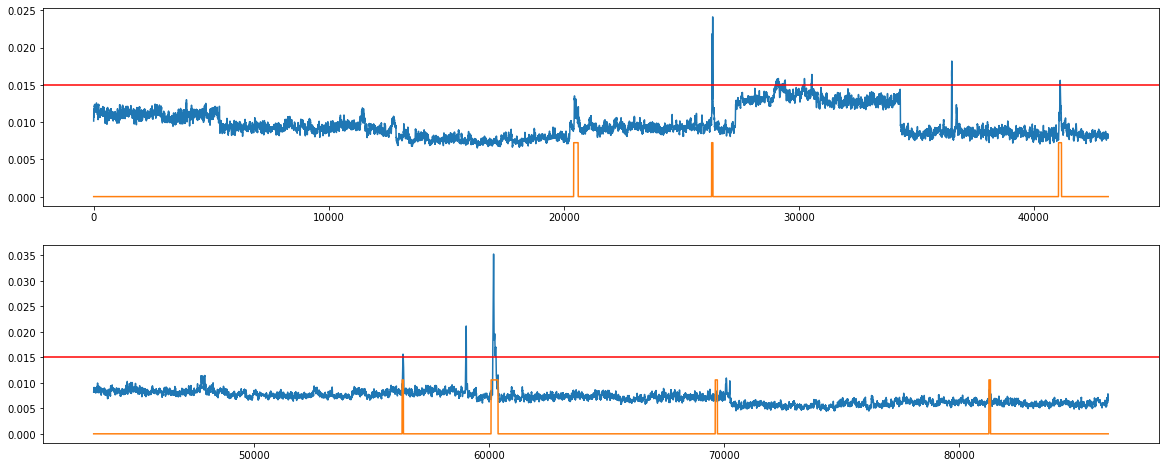

In [27]:
print(f"Normal Experiement, Best -> f1: {tapr_result['best']:.4f}")
dataset.check_graph(sma, attack, piece=2, THRESHOLD=tapr_result['best_threshold'])

Specific-Feature based Experiement, Best -> f1: 0.5480


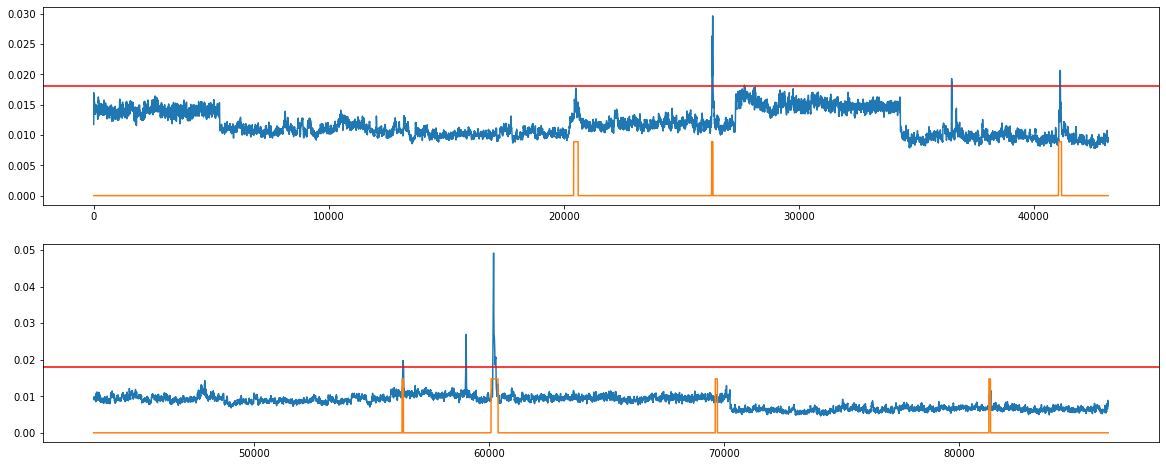

In [28]:
print(f"Specific-Feature based Experiement, Best -> f1: {spec_tapr_result['best']:.4f}")
dataset.check_graph(spec_sma, attack, piece=2, THRESHOLD=spec_tapr_result['best_threshold'])

점수를 파일로 저장합니다.

In [ ]:
score_df = pd.DataFrame(columns=['t', 'F1', 'TaP', 'TaR'])

In [ ]:
for i, tp in enumerate(tapr_result['results']):
    score_df.loc[len(score_df)] = [0.0001*i, tp['f1'], tp['TaP'], tp['TaR']]

for i, tp in enumerate(spec_tapr_result['results']):
    score_df.loc[len(score_df)] = [0.0001*i, tp['f1'], tp['TaP'], tp['TaR']]

In [ ]:
score_df.to_csv(f"tapr_result_{current_time}.csv")

모든 실험 결과(최상의 결과)를 한 그림에 표현할 수 잇도록 작성합니다.

In [ ]:
_, axs = plt.subplots(2, figsize=(20, 4 * 2))
l = sma.shape[0]
chunk = l // 2

for i in range(2):
    L = i * chunk
    R = min(L + chunk, l)
    xticks = range(L, R)
    axs[i].plot(xticks, sma[L:R], color='green', label='MSE (Normal)')
    axs[i].plot(xticks, spec_sma[L:R], color='blue', label='MSE (with PCC)')

    if len(sma[L:R]) > 0:
        peak = max(sma[L:R])
        axs[i].plot(xticks, attack[L:R] * peak * 0.3, color='darkorange', label='Attack Point')
            
    axs[i].axhline(y=tapr_result['best_threshold'], color='orangered', label=f"Threshold (Normal, v: {tapr_result['best_threshold']:.4f}, F1: {tapr_result['best']:.4f})")
    axs[i].axhline(y=spec_tapr_result['best_threshold'], color='red', label=f"Threshold (with PCC, v: {spec_tapr_result['best_threshold']:.4f}, F1: {spec_tapr_result['best']:.4f})")
    axs[i].set_title(f'MSE-based Error Graph and Threshold Results, Seq: [{L} - {R} sec.]')
    axs[i].legend()
plt.show()

# 2. 클러스터링에 기반한 성능 평가

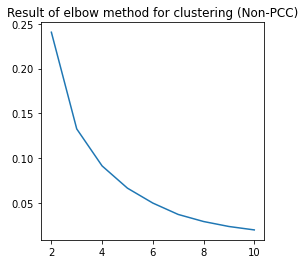

In [25]:
_l = []
for k in range(2, 11):
    _kmeans = KMeans(n_clusters=k)
    _kmeans.fit(anomaly_score.reshape(-1,1))
    inte = _kmeans.inertia_
    _l.append(inte)
plt.figure(figsize=(4,4))
plt.plot(range(2,11), _l, label='Inertia')
plt.title('Result of elbow method for clustering (Non-PCC)')
plt.show()

In [26]:
km_model = KMeans(n_clusters=4)
km_model.fit(anomaly_score.reshape(-1, 1).astype('float'))
train_pred_cluster = km_model.predict(anomaly_score.reshape(-1, 1).astype('float'))

In [27]:
train_pred_cluster, train_pred_cluster.shape, np.unique(train_pred_cluster)

(array([3, 3, 1, ..., 2, 2, 2], dtype=int32),
 (86341,),
 array([0, 1, 2, 3], dtype=int32))

In [28]:
len_list = []
for i in range(0, len(np.unique(train_pred_cluster))):
    len_list.append(len(np.where(train_pred_cluster == i)[0]))
len_list

[36016, 6154, 26961, 17210]

In [29]:
pred_cluster = km_model.predict(sma.reshape(-1, 1))

In [30]:
pred_cluster, pred_cluster.shape, np.unique(pred_cluster)

(array([3, 3, 3, ..., 2, 2, 2], dtype=int32),
 (86341,),
 array([0, 1, 2, 3], dtype=int32))

In [31]:
train_mean_list = [(i / len(train_pred_cluster)) for i in len_list]
train_mean_list = np.array(train_mean_list)
train_mean_list, train_mean_list.shape

(array([0.4171367 , 0.07127552, 0.31226185, 0.19932593]), (4,))

In [32]:
k_anomaly_score = pd.Series([0.] * len(spec_y_pred))
for i in range(len(np.unique(pred_cluster))):
    _anomaly_score = np.mean(abs(spec_valid_y[np.where(pred_cluster == i)] - \
                                 spec_y_pred[np.where(pred_cluster == i)]), axis=1)
    _anomaly_score = _anomaly_score + (_anomaly_score*train_mean_list[i])
    k_anomaly_score.loc[np.where(pred_cluster == i)] = _anomaly_score
    
k_anomaly_score = k_anomaly_score.to_numpy()
k_anomaly_score, k_anomaly_score.shape

(array([0.01407741, 0.01427946, 0.02304723, ..., 0.00834913, 0.00638034,
        0.00783707]),
 (86341,))

In [37]:
k_anomaly_sma = pd.Series(k_anomaly_score)
k_anomaly_sma = k_anomaly_sma.rolling(window=20, min_periods=1).median()

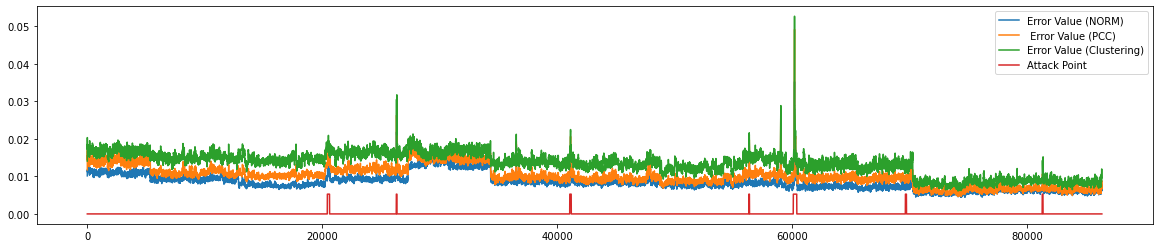

In [38]:
plt.figure(figsize=(20, 4))
L = 0
R = len(spec_sma)
xticks = range(L, R)
plt.plot(xticks, sma, label='Error Value (NORM)')
plt.plot(xticks, spec_sma, label=' Error Value (PCC)')
plt.plot(xticks, k_anomaly_sma, label='Error Value (Clustering)')
peak = max(k_anomaly_sma[L:R])
plt.plot(xticks, attack[L:R] * peak * 0.1, label='Attack Point')
plt.legend()
plt.show()

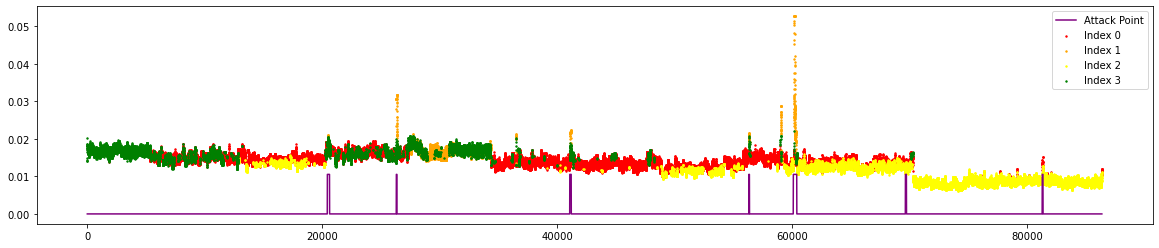

In [39]:
plt.figure(figsize=(20, 4))
L = 0
R = len(spec_sma)
xticks = range(L, R)
plt.scatter(np.where(pred_cluster == 0)[0], \
             k_anomaly_sma.loc[np.where(pred_cluster == 0)], s=2, color='red', label='Index 0')
plt.scatter(np.where(pred_cluster == 1)[0], \
             k_anomaly_sma.loc[np.where(pred_cluster == 1)], s=2, color='orange', label='Index 1')
plt.scatter(np.where(pred_cluster == 2)[0], \
            k_anomaly_sma.loc[np.where(pred_cluster == 2)],  s=2, color='yellow', label='Index 2')
plt.scatter(np.where(pred_cluster == 3)[0], \
             k_anomaly_sma.loc[np.where(pred_cluster == 3)], s=2, color='green', label='Index 3')
if len(k_anomaly_sma[L:R]) > 0:
    peak = max(k_anomaly_sma[L:R])
    plt.plot(xticks, attack[L:R] * peak * 0.2, color='purple', label='Attack Point')
plt.legend()
plt.show()

In [40]:
th_km_model = KMeans(n_clusters=3)
th_pred = th_km_model.fit_predict(k_anomaly_sma.to_numpy().reshape(-1, 1))

In [41]:
opcode = []
for m in range(0, len(np.unique(th_pred))):
    v = k_anomaly_sma.mean() - k_anomaly_sma.iloc[np.where(th_pred == m)].mean()
    if v < 0:
        opcode.append(1 - (k_anomaly_sma.mean() / k_anomaly_sma.iloc[np.where(th_pred == m)].mean()))
    else:
        opcode.append(-((k_anomaly_sma.mean() / k_anomaly_sma.iloc[np.where(th_pred == m)].mean()) - 1))
opcode = np.array(opcode)
opcode*0.03

array([-0.01703678, -0.00032005,  0.00554332])

In [42]:
k_anomaly_score

array([0.01407741, 0.01427946, 0.02304723, ..., 0.00834913, 0.00638034,
       0.00783707])

In [43]:
anomaly_score_df = pd.Series(k_anomaly_score)

score_mean_list = [] 
for p in np.unique(th_pred):
    score_mean_list.append(anomaly_score_df.iloc[np.where(th_pred == p)].mean())

score_mean_list = np.array(score_mean_list)
total = score_mean_list.mean()

In [44]:
threshold_list = []
for m in range(0, len(np.unique(th_pred))):
    if np.isnan(score_mean_list[m]):
        threshold_list.append(0)
    else:
        threshold_list.append(total + (score_mean_list[m] * opcode[m]))

In [45]:
threshold_df = pd.Series([0] * len(anomaly_score_df))

for i in range(len(threshold_list)):
    threshold_df.iloc[np.where(th_pred == i)] = threshold_list[i]

threshold = threshold_df.to_numpy()
    
threshold, np.unique(threshold)

(array([0.01297819, 0.01297819, 0.01297819, ..., 0.01297819, 0.00800782,
        0.00800782]),
 array([0.00800782, 0.01297819, 0.01620946]))

In [46]:
threshold_sma = pd.Series(threshold)
threshold_sma = threshold_sma.rolling(window=863, min_periods=1).median().to_numpy()

labels = np.zeros_like(k_anomaly_sma)
for i, t in enumerate(threshold_sma):
    if k_anomaly_sma[i] > t:
        labels[i] = 1
    
final_labels = dataset.fill_blank(ts, labels, valid_dataset.ts)
tapr_result = etapr.evaluate(anomalies=attack_labels, predictions=final_labels)
print(f"f1 -> {tapr_result['f1']}, tap -> {tapr_result['TaP']}, tar -> {tapr_result['TaR']}")

f1 -> 0.02730799271926665431100000069, tap -> 0.01387847641982054567030403732, tar -> 0.8441581241355899127474230484


In [47]:
t_score_df = pd.DataFrame(columns=['alpha','F1','taP','taR'])
best = 0
best_alpha = 0

def get_score(alpha):
    threshold_sma = pd.Series(threshold)
    threshold_sma = threshold_sma.rolling(window=863, min_periods=1).median().to_numpy()
    threshold_sma = (threshold_sma * (1.0 + alpha))
    
    labels = np.zeros_like(k_anomaly_sma)
    for i, t in enumerate(threshold_sma):
        if k_anomaly_sma[i] > t:
            labels[i] = 1
    
    final_labels = dataset.fill_blank(ts, labels, valid_dataset.ts)
    tapr_result = etapr.evaluate(anomalies=attack_labels, predictions=final_labels)
    
    return [1.0 + alpha, tapr_result['f1'], tapr_result['TaP'], tapr_result['TaR']]

with Pool(None) as p:
    result = p.map(get_score, np.arange(0.00, 2.01, 0.01))

In [48]:
t_score_df = pd.DataFrame(columns=['alpha','F1','taP','taR'])
for i in tqdm(result):
    t_score_df.loc[len(t_score_df)] = i

  0%|          | 0/201 [00:00<?, ?it/s]

In [49]:
t_score_df.iloc[np.where(t_score_df['F1'] == t_score_df['F1'].max())]

,alpha,F1,taP,taR
52,1.52,0.6879134986751123192529939146,0.8232556415664073415728956574,0.5907886267589850261136564088


In [50]:
t_score_df.to_csv(f"tapr_result_with_no_pcc_threshold_{current_time}.csv")

In [51]:
threshold_sma = pd.Series(threshold)
threshold_sma = threshold_sma.rolling(window=863, min_periods=1).median().to_numpy()
threshold_sma = (threshold_sma * 1.372)
                 
labels = np.zeros_like(k_anomaly_sma)
for i, t in enumerate(threshold_sma):
    if k_anomaly_sma[i] > t:
        labels[i] = 1
labels, labels.shape, np.unique(labels)

(array([0., 0., 0., ..., 1., 0., 0.]), (86341,), array([0., 1.]))

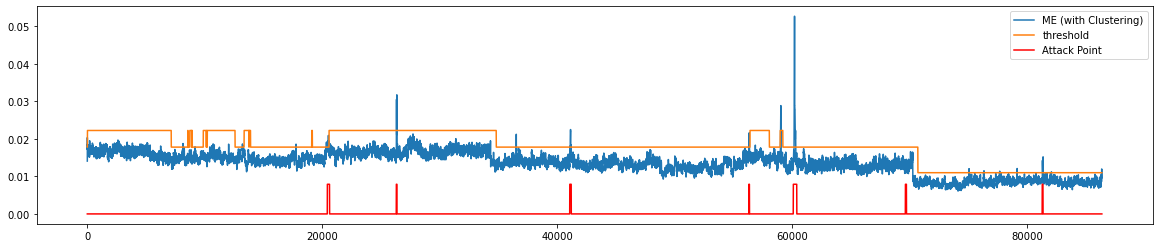

In [52]:
plt.figure(figsize=(20, 4))
xticks = range(0, len(k_anomaly_sma))
plt.plot(xticks, k_anomaly_sma, label='ME (with Clustering)')
plt.plot(xticks, threshold_sma, label='threshold')
plt.plot(xticks, attack * peak * 0.15, color='red', label='Attack Point')
plt.legend()
plt.show()

# 3. 클러스터링 + 상대적 임계값에 기반한 성능 평가

또한, 최적의 임계값을 계산하기 위해 평균 갯수에 대비하여, 각 클러스터링 인덱스가 차지하고 있는 비중을 계산합니다.</br>
이 방법은 정확하진 않습니다. 그러나, 제어시스템은 공정을 운영할 때 나타나는 일정한 시퀀스들이 존재합니다.</br>
따라서, K-mean 알고리즘을 통해 prediction value들이 군집하는 경향성(시퀀스의 특징)을 대략적으로 예측할 수 있습니다.</br>

군집을 위한 적절한 클러스터링 갯수를 6으로 설정하였습니다.
학습 데이터에서 PCC에 기반하여 오차값을 측정했을 때, 대략 6가지의 형태가 보입니다.


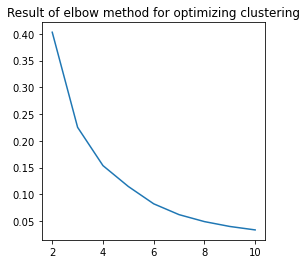

In [45]:
_l = []
for k in range(2, 11):
    _kmeans = KMeans(n_clusters=k)
    _kmeans.fit(spec_anomaly_score.reshape(-1,1))
    inte = _kmeans.inertia_
    _l.append(inte)
plt.figure(figsize=(4,4))
plt.plot(range(2,11), _l, label='Inertia')
plt.title('Result of elbow method for optimizing clustering')
plt.show()

In [46]:
km_model = KMeans(n_clusters=4)
km_model.fit(spec_anomaly_score.reshape(-1, 1).astype('float'))
train_pred_cluster = km_model.predict(spec_anomaly_score.reshape(-1, 1).astype('float'))

In [47]:
train_pred_cluster, train_pred_cluster.shape, np.unique(train_pred_cluster)

(array([1, 1, 3, ..., 0, 0, 0], dtype=int32),
 (86341,),
 array([0, 1, 2, 3], dtype=int32))

In [48]:
len_list = []
for i in range(0, len(np.unique(train_pred_cluster))):
    len_list.append(len(np.where(train_pred_cluster == i)[0]))
len_list

[21797, 20449, 37184, 6911]

In [49]:
pred_cluster = km_model.predict(spec_sma.reshape(-1, 1))

In [50]:
pred_cluster, pred_cluster.shape, np.unique(pred_cluster)

(array([1, 1, 1, ..., 0, 0, 0], dtype=int32),
 (86341,),
 array([0, 1, 2, 3], dtype=int32))

In [51]:
train_mean_list = [(i / len(train_pred_cluster)) for i in len_list]
train_mean_list = np.array(train_mean_list)
train_mean_list, train_mean_list.shape

(array([0.25245248, 0.23683997, 0.43066446, 0.08004308]), (4,))

각 클러스터링 인덱스 별로 차지하는 갯수를 구합니다.

In [52]:
k_spec_anomaly_score = pd.Series([0.] * len(spec_y_pred))
for i in range(len(np.unique(pred_cluster))):
    _anomaly_score = np.mean(abs(spec_valid_y[np.where(pred_cluster == i)] - \
                                 spec_y_pred[np.where(pred_cluster == i)]), axis=1)
    _anomaly_score = _anomaly_score + (_anomaly_score*train_mean_list[i])
    k_spec_anomaly_score.loc[np.where(pred_cluster == i)] = _anomaly_score
    
k_spec_anomaly_score = k_spec_anomaly_score.to_numpy()
k_spec_anomaly_score, k_spec_anomaly_score.shape

(array([0.01451774, 0.01472611, 0.02376813, ..., 0.0079686 , 0.00608954,
        0.00747988]),
 (86341,))

In [53]:
k_spec_anomaly_sma = pd.Series(k_spec_anomaly_score)
k_spec_anomaly_sma = k_spec_anomaly_sma.rolling(window=20, min_periods=1).median()

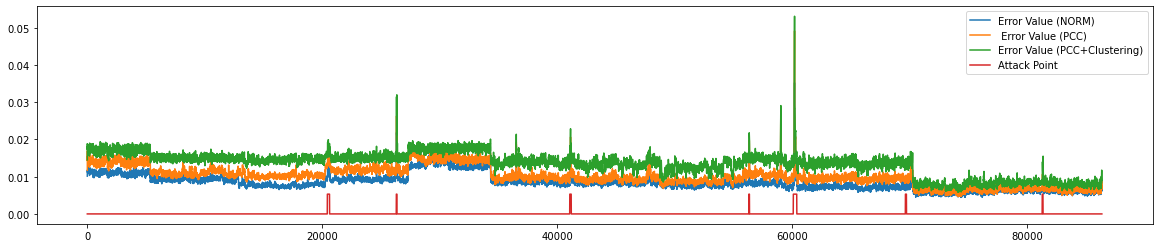

In [54]:
plt.figure(figsize=(20, 4))
L = 0
R = len(spec_sma)
xticks = range(L, R)
plt.plot(xticks, sma, label='Error Value (NORM)')
plt.plot(xticks, spec_sma, label=' Error Value (PCC)')
plt.plot(xticks, k_spec_anomaly_sma, label='Error Value (PCC+Clustering)')
peak = max(k_spec_anomaly_sma[L:R])
plt.plot(xticks, attack[L:R] * peak * 0.1, label='Attack Point')
plt.legend()
plt.show()

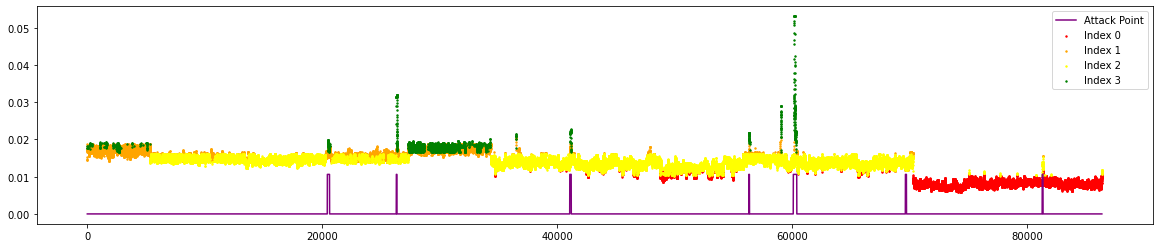

In [55]:
plt.figure(figsize=(20, 4))
L = 0
R = len(spec_sma)
xticks = range(L, R)
plt.scatter(np.where(pred_cluster == 0)[0], \
             k_spec_anomaly_sma.loc[np.where(pred_cluster == 0)], s=2, color='red', label='Index 0')
plt.scatter(np.where(pred_cluster == 1)[0], \
             k_spec_anomaly_sma.loc[np.where(pred_cluster == 1)], s=2, color='orange', label='Index 1')
plt.scatter(np.where(pred_cluster == 2)[0], \
            k_spec_anomaly_sma.loc[np.where(pred_cluster == 2)],  s=2, color='yellow', label='Index 2')
plt.scatter(np.where(pred_cluster == 3)[0], \
             k_spec_anomaly_sma.loc[np.where(pred_cluster == 3)], s=2, color='green', label='Index 3')
if len(k_spec_anomaly_sma[L:R]) > 0:
    peak = max(k_spec_anomaly_sma[L:R])
    plt.plot(xticks, attack[L:R] * peak * 0.2, color='purple', label='Attack Point')
plt.legend()
plt.show()

In [56]:
th_km_model = KMeans(n_clusters=4)
th_pred = th_km_model.fit_predict(k_spec_anomaly_sma.to_numpy().reshape(-1, 1))
th_pred

array([2, 2, 2, ..., 1, 1, 1], dtype=int32)

In [57]:
opcode = []
print(f"Total means: {k_spec_anomaly_sma.mean()}")
for m in range(0, len(np.unique(th_pred))):
    print(f"Means of cluster {m}: {k_spec_anomaly_sma.iloc[np.where(th_pred == m)].mean()}")
    v = k_spec_anomaly_sma.mean() - k_spec_anomaly_sma.iloc[np.where(th_pred == m)].mean()
    if v < 0:
        opcode.append(1 - (k_spec_anomaly_sma.mean() / k_spec_anomaly_sma.iloc[np.where(th_pred == m)].mean()))
    else:
        opcode.append(-((k_spec_anomaly_sma.mean() / k_spec_anomaly_sma.iloc[np.where(th_pred == m)].mean()) - 1))
opcode = np.array(opcode)
opcode

Total means: 0.013474456542744897
Means of cluster 0: 0.012971792847510702
Means of cluster 1: 0.008171900953687729
Means of cluster 2: 0.01491356596914183
Means of cluster 3: 0.017759691697334625


array([-0.03875052, -0.64887663,  0.09649667,  0.24128995])

In [58]:
k_spec_anomaly_score

array([0.01451774, 0.01472611, 0.02376813, ..., 0.0079686 , 0.00608954,
       0.00747988])

In [59]:
spec_anomaly_score_df = pd.Series(k_spec_anomaly_score)

score_mean_list = [] 
for p in np.unique(th_pred):
    score_mean_list.append(spec_anomaly_score_df.iloc[np.where(th_pred == p)].mean())

score_mean_list = np.array(score_mean_list)
total = score_mean_list.mean()

In [60]:
threshold_list = []
for m in range(0, len(np.unique(th_pred))):
    if np.isnan(score_mean_list[m]):
        threshold_list.append(0)
    else:
        threshold_list.append(total + (score_mean_list[m] * opcode[m]))
threshold_list

[0.013255441582866444,
 0.008200147342019388,
 0.01523748956260312,
 0.01810834046670457]

위 계산한 각 클러스터링 인덱스의 임계치들을 score에 각각 부여해줍니다.

In [61]:
threshold_df = pd.Series([0] * len(spec_anomaly_score_df))

for i in range(len(threshold_list)):
    threshold_df.iloc[np.where(th_pred == i)] = threshold_list[i]

threshold = threshold_df.to_numpy()
    
threshold, np.unique(threshold)

(array([0.01523749, 0.01523749, 0.01523749, ..., 0.00820015, 0.00820015,
        0.00820015]),
 array([0.00820015, 0.01325544, 0.01523749, 0.01810834]))

상대적 임계치를 별도로 튜닝하지 않아 점수가 낮은 편입니다. 이에 튜닝 작업을 진행합니다.

In [62]:
threshold_sma = pd.Series(threshold)
threshold_sma = threshold_sma.rolling(window=1, min_periods=1).median().to_numpy()
threshold_sma = (threshold_sma * 1.37)

labels = np.zeros_like(k_spec_anomaly_sma)
for i, t in enumerate(threshold_sma):
    if k_spec_anomaly_sma[i] > t:
        labels[i] = 1
    
final_labels = dataset.fill_blank(ts, labels, valid_dataset.ts)
tapr_result = etapr.evaluate(anomalies=attack_labels, predictions=final_labels)
print(f"f1 -> {tapr_result['f1']}, tap -> {tapr_result['TaP']}, tar -> {tapr_result['TaR']}")

f1 -> 0.03004498748907695928649692627, tap -> 0.01526952519485423239859542356, tar -> 0.9285714285714285714285714286


한번에 하나씩 계산하면 다량의 시간이 계산되므로, Pool을 사용했습니다.

In [75]:
t_score_df = pd.DataFrame(columns=['alpha','F1','taP','taR'])
best = 0
best_alpha = 0

def get_score(alpha):
    threshold_sma = pd.Series(threshold)
    threshold_sma = threshold_sma.rolling(window=863, min_periods=1).median().to_numpy()
    threshold_sma = (threshold_sma * (1.0 + alpha))
    
    labels = np.zeros_like(k_spec_anomaly_sma)
    for i, t in enumerate(threshold_sma):
        if k_spec_anomaly_sma[i] > t:
            labels[i] = 1
    
    final_labels = dataset.fill_blank(ts, labels, valid_dataset.ts)
    tapr_result = etapr.evaluate(anomalies=attack_labels, predictions=final_labels)
    
    return [1.0 + alpha, tapr_result['f1'], tapr_result['TaP'], tapr_result['TaR']]

with Pool(None) as p:
    result = p.map(get_score, np.arange(0.00, 2.01, 0.01))

In [76]:
t_score_df = pd.DataFrame(columns=['alpha','F1','taP','taR'])
for i in tqdm(result):
    t_score_df.loc[len(t_score_df)] = i

  0%|          | 0/201 [00:00<?, ?it/s]

성능이 개선되었는지 확인합니다. alpha가 1.5일 때, 최고 f1-score가 0.6425로 상당 부분 개선된 것을 알 수 있습니다.

In [77]:
t_score_df.iloc[np.where(t_score_df['F1'] == t_score_df['F1'].max())]

,alpha,F1,taP,taR
37,1.37,0.6391365751682963989482799904,0.7570187046679497448929211794,0.5530207805781168589362654972


In [78]:
t_score_df.to_csv(f"tapr_result_with_threshold_{current_time}.csv")

In [51]:
threshold_sma = pd.Series(threshold)
threshold_sma = threshold_sma.rolling(window=863, min_periods=1).median().to_numpy()
threshold_sma = (threshold_sma * 1.372)
                 
labels = np.zeros_like(k_spec_anomaly_sma)
for i, t in enumerate(threshold_sma):
    if k_spec_anomaly_sma[i] > t:
        labels[i] = 1
labels, labels.shape, np.unique(labels)

(array([0., 0., 0., ..., 0., 0., 0.]), (86341,), array([0., 1.]))

In [52]:
plt.figure(figsize=(20, 4))
xticks = range(0, len(k_spec_anomaly_sma))
plt.plot(xticks, k_anomaly_sma, label='ME (with Clustering)')
plt.plot(xticks, k_spec_anomaly_sma, label='ME (with PCC+Clustering)')
plt.plot(xticks, threshold_sma, label='threshold')
plt.plot(xticks, attack * peak * 0.15, color='red', label='Attack Point')
plt.legend()
plt.show()

NameError: name 'k_anomaly_sma' is not defined

<Figure size 1440x288 with 0 Axes>

# Test

In [38]:
test_raw = None

for p in glob.glob('test/*.csv'):
    data = pd.read_csv(p)
    if test_raw is None:
        test_raw = data
        continue
    test_raw = pd.concat([test_raw, data])

In [39]:
test_raw

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-14 17:40:01,-2.3266,0,11.90338,0.00029,4.58679,-0.2379,12.58870,70,1,...,1.21017,29.55186,8.81242,28.99807,421.06122,1,1036.90637,12.0,50,121
1,2021-07-14 17:40:02,-2.4180,0,11.90338,-0.00058,4.58679,-0.2964,12.58870,70,1,...,1.20865,29.53850,8.81242,28.99807,417.86029,1,1036.90637,12.0,50,139
2,2021-07-14 17:40:03,-2.5614,0,11.90338,-0.00058,4.58679,-0.2964,12.58870,70,1,...,1.20789,29.51829,8.81242,29.99137,417.86029,1,1036.90637,12.0,50,139
3,2021-07-14 17:40:04,-2.7243,0,11.90338,-0.00043,4.58679,-0.4704,12.58870,70,1,...,1.20789,29.48624,8.81242,32.97053,413.71887,1,1036.90637,12.0,50,113
4,2021-07-14 17:40:05,-2.8614,0,11.90338,-0.00051,4.58679,-0.5540,12.58870,70,1,...,1.20636,29.46908,8.81242,29.99137,411.04242,1,1036.90637,12.0,50,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82795,2021-07-14 14:59:56,-3.0114,0,11.90338,0.00065,13.24615,-0.2966,12.58874,70,1,...,1.20255,29.27224,5.86356,263.36804,339.87994,1,987.14362,12.0,50,2287
82796,2021-07-14 14:59:57,-2.5903,0,11.90338,0.00210,13.24615,0.0445,12.58874,70,1,...,1.20255,29.27224,5.86356,259.39594,336.11835,1,987.14362,12.0,50,2513
82797,2021-07-14 14:59:58,-2.1569,0,11.90338,0.00145,13.24615,0.0485,12.58874,70,1,...,1.20255,29.26308,5.86356,255.42348,333.58649,1,987.14362,12.0,50,2776
82798,2021-07-14 14:59:59,-2.1569,0,11.91101,0.00080,13.25378,0.0485,12.58874,70,1,...,1.20255,29.25736,5.86356,260.38889,331.38019,1,987.14362,12.0,50,2962


In [41]:
test_dataset = TrainDataset(test_raw)

In [42]:
test_spec_df = dataset.normalize(test_dataset.df[spec_col], spec_tag_min, spec_tag_max)
test_spec_df = test_spec_df.ewm(alpha=0.9).mean()

In [43]:
hai_test_dataset = HaiDataset(test_dataset.ts, test_spec_df, 1, None, 59, 60)
test_spec_X = hai_test_dataset.get_train_set()
test_spec_y = hai_test_dataset.get_label_set()

100%|██████████| 274741/274741 [00:36<00:00, 7577.37it/s]


# of valid windows: 274623


In [75]:
check_ts = hai_test_dataset.get_ts_set()

In [44]:
spec_y_test = spec_model.predict(test_spec_X)

In [45]:
tmp = []

for i in range(len(test_spec_y)):
    tmp.append(abs(test_spec_y[i] - spec_y_test[i]))

spec_test_anomaly_score = np.mean(tmp, axis=1)
spec_test_anomaly_score, spec_test_anomaly_score.shape

(array([0.0073233 , 0.00763736, 0.00815304, ..., 0.0058098 , 0.01002671,
        0.00913733], dtype=float32),
 (274623,))

In [46]:
spec_test_sma = pd.DataFrame()
anomaly_score_series = pd.Series(spec_test_anomaly_score)
spec_test_sma = anomaly_score_series.rolling(window=20, min_periods=1).median().to_numpy()
spec_test_sma.shape

(274623,)

In [51]:
test_pred_cluster = km_model.predict(spec_test_anomaly_score.reshape(-1, 1).astype('float'))

In [55]:
test_pred_cluster, test_pred_cluster.shape, np.unique(test_pred_cluster)

(array([1, 1, 1, ..., 1, 2, 2], dtype=int32),
 (274623,),
 array([0, 1, 2, 3], dtype=int32))

In [56]:
len_list = []
for i in range(0, len(np.unique(test_pred_cluster))):
    len_list.append(len(np.where(test_pred_cluster == i)[0]))
len_list

[21754, 143500, 103293, 6076]

In [57]:
pred_cluster = km_model.predict(spec_test_sma.reshape(-1, 1))
pred_cluster, pred_cluster.shape, np.unique(pred_cluster)

(array([1, 1, 1, ..., 2, 2, 2], dtype=int32),
 (274623,),
 array([0, 1, 2, 3], dtype=int32))

In [58]:
test_mean_list = [(i / len(test_pred_cluster)) for i in len_list]
test_mean_list = np.array(test_mean_list)
test_mean_list, test_mean_list.shape

(array([0.07921405, 0.52253453, 0.37612654, 0.02212488]), (4,))

In [59]:
k_spec_anomaly_score = pd.Series([0.] * len(spec_y_test))
for i in range(len(np.unique(pred_cluster))):
    _anomaly_score = np.mean(abs(test_spec_y[np.where(pred_cluster == i)] - \
                                 spec_y_test[np.where(pred_cluster == i)]), axis=1)
    _anomaly_score = _anomaly_score + (_anomaly_score*train_mean_list[i])
    k_spec_anomaly_score.loc[np.where(pred_cluster == i)] = _anomaly_score

In [61]:
k_spec_anomaly_score = k_spec_anomaly_score.to_numpy()
k_spec_anomaly_score, k_spec_anomaly_score.shape

(array([0.00916208, 0.00955499, 0.01020016, ..., 0.00826968, 0.01427205,
        0.0130061 ]),
 (274623,))

In [62]:
k_spec_anomaly_sma = pd.Series(k_spec_anomaly_score)
k_spec_anomaly_sma = k_spec_anomaly_sma.rolling(window=20, min_periods=1).median()

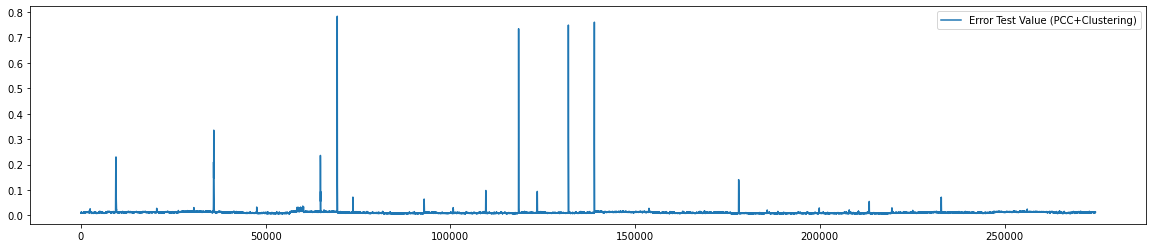

In [64]:
plt.figure(figsize=(20, 4))
L = 0
R = len(spec_test_sma)
xticks = range(L, R)
plt.plot(xticks, k_spec_anomaly_sma, label='Error Test Value (PCC+Clustering)')
plt.legend()
plt.show()

In [65]:
th_pred = th_km_model.fit_predict(k_spec_anomaly_sma.to_numpy().reshape(-1, 1))

In [66]:
opcode = []
for m in range(0, len(np.unique(th_pred))):
    v = k_spec_anomaly_sma.mean() - k_spec_anomaly_sma.iloc[np.where(th_pred == m)].mean()
    if v < 0:
        opcode.append(1 - (k_spec_anomaly_sma.mean() / k_spec_anomaly_sma.iloc[np.where(th_pred == m)].mean()))
    else:
        opcode.append(-((k_spec_anomaly_sma.mean() / k_spec_anomaly_sma.iloc[np.where(th_pred == m)].mean()) - 1))
opcode = np.array(opcode)
opcode

array([-0.06248459,  0.98389683,  0.91419858])

In [67]:
spec_anomaly_score_df = pd.Series(k_spec_anomaly_score)
score_mean_list = [] 
for p in np.unique(th_pred):
    score_mean_list.append(spec_anomaly_score_df.iloc[np.where(th_pred == p)].mean())

score_mean_list = np.array(score_mean_list)
total = score_mean_list.mean()

In [68]:
threshold_list = []
for m in range(0, len(np.unique(th_pred))):
    if np.isnan(score_mean_list[m]):
        threshold_list.append(0)
    else:
        threshold_list.append(total + (score_mean_list[m] * opcode[m]))
threshold_list

threshold_df = pd.Series([0] * len(spec_anomaly_score_df))

In [70]:
for i in range(len(threshold_list)):
    threshold_df.iloc[np.where(th_pred == i)] = threshold_list[i]

threshold = threshold_df.to_numpy()

In [84]:
for alpha in np.arange(0.00, 2.01, 0.01):
    threshold_sma = pd.Series(threshold)
    threshold_sma = threshold_sma.rolling(window=2746, min_periods=1).median().to_numpy()
    threshold_sma = (threshold_sma * (1.0 + alpha))
    
    labels = np.zeros_like(k_spec_anomaly_sma)
    for i, t in enumerate(threshold_sma):
        if k_spec_anomaly_sma[i] > t:
            labels[i] = 1
    
    # final_labels = dataset.fill_blank(ts, labels, valid_dataset.ts)
    submission = pd.read_csv('./data/sample_submission.csv')
    submission.index = submission['timestamp']
    submission.loc[check_ts, 'attack'] = labels
    submission.to_csv('./results/lstm_baseline_{}.csv'.format(int(alpha*100)), index=False)

KeyboardInterrupt: 